# Multi-Fidelity GP with Expected Improvement (1D Example)

This tutorial demonstrates training a multi-fidelity GP on both low and high fidelity data, then optimizing using Expected Improvement on the high-fidelity function only.

In [ ]:
# Colab setup (run once per session)
# !pip -q install botorch scipy

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from botorch.acquisition import LogExpectedImprovement as ExpectedImprovement
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch import fit_gpytorch_mll
from pyDOE import lhs
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

torch.manual_seed(42)
np.random.seed(42)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

/opt/homebrew/Caskroom/miniconda/base/envs/vital/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the Multi-Fidelity Forrester Function

The Forrester function has high and low fidelity versions.

In [2]:
def forrester_high_fidelity(x):
    """High-fidelity Forrester function"""
    return -((6*x - 2)**2 * torch.sin(12*x - 4))

def forrester_low_fidelity(x):
    """Low-fidelity Forrester function (approximation of high-fidelity)"""
    A = 0.5
    B = 10
    C = -10
    return -(A * (-forrester_high_fidelity(x)) + B * (x - 0.5) + C)

def forrester_multifidelity(x_with_fidelity):
    """Multi-fidelity function where last dimension is fidelity parameter"""
    x = x_with_fidelity[..., :-1]  # Design variables
    s = x_with_fidelity[..., -1:]  # Fidelity parameter
    
    f_low = forrester_low_fidelity(x)
    f_high = forrester_high_fidelity(x)
    
    # Linear interpolation between low and high fidelity
    return (1 - s) * f_low + s * f_high

# Domain bounds
bounds = torch.tensor([[0.0], [1.0]], **tkwargs)

## Generate Initial Training Data

In [3]:
# Initial training data
n_low = 15  # Number of low-fidelity samples
n_high = 4  # Number of high-fidelity samples

# Generate low-fidelity data (s=0.0)
X_low = torch.tensor(lhs(1,n_low), **tkwargs)
#X_low = torch.rand(n_low, 1, **tkwargs)
s_low = torch.zeros(n_low, 1, **tkwargs)
X_low_full = torch.cat([X_low, s_low], dim=1)
y_low = forrester_multifidelity(X_low_full)  # Negate for minimization

# Generate high-fidelity data (s=1.0)
X_high = torch.tensor(lhs(1,n_high), **tkwargs)
s_high = torch.ones(n_high, 1, **tkwargs)
X_high_full = torch.cat([X_high, s_high], dim=1)
y_high = forrester_multifidelity(X_high_full)  # Negate for minimization

# Combine training data
train_X = torch.cat([X_low_full, X_high_full], dim=0)
train_y = torch.cat([y_low, y_high], dim=0)

print(f"Training data shape: {train_X.shape}")
print(f"Training labels shape: {train_y.shape}")

Training data shape: torch.Size([19, 2])
Training labels shape: torch.Size([19, 1])


In [4]:
X_low

tensor([[0.8555],
        [0.6680],
        [0.4039],
        [0.9455],
        [0.2399],
        [0.1300],
        [0.5244],
        [0.1821],
        [0.8808],
        [0.5734],
        [0.3437],
        [0.6472],
        [0.7980],
        [0.0250],
        [0.2771]], dtype=torch.float64)

## Initialize the Multi-Fidelity GP Model

In [5]:
def initialize_model(train_X, train_y):
    """Initialize and fit a SingleTaskMultiFidelityGP model"""
    model = SingleTaskMultiFidelityGP(
        train_X, 
        train_y, 
        outcome_transform=Standardize(m=1),
        data_fidelities=[1]  # Fidelity is in dimension 1 (0-indexed)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model = initialize_model(train_X, train_y)
print("Model initialized and fitted!")

Model initialized and fitted!


## Visualize Initial Model Predictions

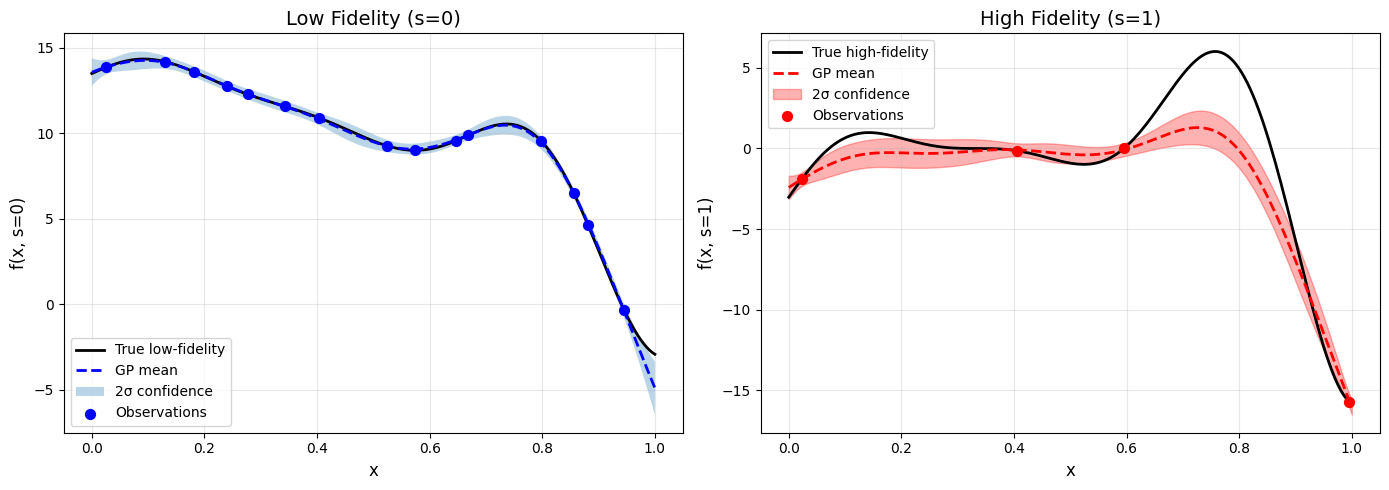

In [6]:
# Create test points
X_test = torch.linspace(0, 1, 200, **tkwargs).unsqueeze(-1)
X_test_low = torch.cat([X_test, torch.zeros_like(X_test)], dim=1)
X_test_high = torch.cat([X_test, torch.ones_like(X_test)], dim=1)

# True function values
y_test_low_true = forrester_multifidelity(X_test_low)
y_test_high_true = forrester_multifidelity(X_test_high)

# Model predictions
with torch.no_grad():
    posterior_low = model.posterior(X_test_low)
    mean_low = posterior_low.mean.squeeze()
    std_low = posterior_low.variance.sqrt().squeeze()
    
    posterior_high = model.posterior(X_test_high)
    mean_high = posterior_high.mean.squeeze()
    std_high = posterior_high.variance.sqrt().squeeze()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Low fidelity
ax1.plot(X_test.numpy(), y_test_low_true.numpy(), 'k-', label='True low-fidelity', linewidth=2)
ax1.plot(X_test.numpy(), mean_low.numpy(), 'b--', label='GP mean', linewidth=2)
ax1.fill_between(X_test.numpy().squeeze(), 
                  (mean_low - 2*std_low).numpy(), 
                  (mean_low + 2*std_low).numpy(), 
                  alpha=0.3, label='2σ confidence')
ax1.scatter(X_low.numpy(), y_low.numpy(), c='blue', s=50, zorder=5, label='Observations')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('f(x, s=0)', fontsize=12)
ax1.set_title('Low Fidelity (s=0)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# High fidelity
ax2.plot(X_test.numpy(), y_test_high_true.numpy(), 'k-', label='True high-fidelity', linewidth=2)
ax2.plot(X_test.numpy(), mean_high.numpy(), 'r--', label='GP mean', linewidth=2)
ax2.fill_between(X_test.numpy().squeeze(), 
                  (mean_high - 2*std_high).numpy(), 
                  (mean_high + 2*std_high).numpy(), 
                  alpha=0.3, color='red', label='2σ confidence')
ax2.scatter(X_high.numpy(), y_high.numpy(), c='red', s=50, zorder=5, label='Observations')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('f(x, s=1)', fontsize=12)
ax2.set_title('High Fidelity (s=1)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Set Up Expected Improvement Acquisition Function (High Fidelity Only)

In [7]:
def get_ei(model, best_f):
    """Get Expected Improvement acquisition function fixed at high fidelity"""
    ei_acqf = ExpectedImprovement(model=model, best_f=best_f)
    
    # Fix the fidelity dimension to 1.0 (high fidelity)
    ei_acqf_fixed = FixedFeatureAcquisitionFunction(
        acq_function=ei_acqf,
        d=2,  # Total dimensions (x + fidelity)
        columns=[1],  # Fidelity dimension
        values=[1.0],  # Fix to high fidelity
    )
    
    return ei_acqf_fixed

# Get best observed high-fidelity value
high_fidelity_mask = train_X[:, 1] == 1.0
best_f = train_y[high_fidelity_mask].max()  # max of negated values (EI maximizes)

ei_acqf = get_ei(model, best_f)
print("Expected Improvement acquisition function created!")

Expected Improvement acquisition function created!


## Run Bayesian Optimization Loop

In [ ]:
n_iterations = 5
cumulative_cost = 0.0

for iteration in range(n_iterations):
    print(f"\n{'='*60}")
    print(f"Iteration {iteration + 1}/{n_iterations}")
    print(f"{'='*60}")
    
    # Get best observed high-fidelity value
    high_fidelity_mask = train_X[:, 1] == 1.0
    best_f = train_y[high_fidelity_mask].max()  # max of negated values
    
    # Get EI acquisition function
    ei_acqf = get_ei(model, best_f)
    
    # Optimize EI over x (fidelity is fixed to 1.0)
    new_x_design, _ = optimize_acqf(
        acq_function=ei_acqf,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=256,
        options={"batch_limit": 5, "maxiter": 200},
    )
    
    # Construct full input with high fidelity
    new_x = ei_acqf._construct_X_full(new_x_design)
    
    # Evaluate at the new point (high fidelity only)
    new_y = forrester_multifidelity(new_x)  # Negate for minimization
    
    # Cost is 1.0 per high-fidelity evaluation
    cost = 1.0
    cumulative_cost += cost
    
    print(f"New query point: x={new_x[0, 0].item():.4f}, s={new_x[0, 1].item():.2f}")
    print(f"Observed value: {new_y.item():.4f}")  # Display actual (non-negated) value
    print(f"Cost: {cost:.1f}, Cumulative cost: {cumulative_cost:.1f}")
    
    # Update training data
    train_X = torch.cat([train_X, new_x], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)
    

    # Refit modelprint(f"Total cost (high-fidelity evaluations): {cumulative_cost:.1f}")

    model = initialize_model(train_X, train_y)
    print("\nOptimization complete!")

    # Find current best at high fidelity
    high_fidelity_mask = train_X[:, 1] == 1.0 
    best_y_neg = train_y[high_fidelity_mask].max()  # max of negated = min of original
    best_x = train_X[high_fidelity_mask][train_y[high_fidelity_mask].argmax(), 0]
    print(f"Best high-fidelity value so far: {-best_y_neg.item():.4f} at x={best_x.item():.4f}")


Iteration 1/5
New query point: x=0.7260, s=1.00
Observed value: 5.5521
Cost: 1.0, Cumulative cost: 1.0

Optimization complete!
Best high-fidelity value so far: -5.5521 at x=0.7260

Iteration 2/5
New query point: x=0.7395, s=1.00
Observed value: 5.8609
Cost: 1.0, Cumulative cost: 2.0

Optimization complete!
Best high-fidelity value so far: -5.8609 at x=0.7395

Iteration 3/5
New query point: x=0.7567, s=1.00
Observed value: 6.0206
Cost: 1.0, Cumulative cost: 3.0

Optimization complete!
Best high-fidelity value so far: -6.0206 at x=0.7567

Iteration 4/5
New query point: x=0.7604, s=1.00
Observed value: 6.0154
Cost: 1.0, Cumulative cost: 4.0

Optimization complete!
Best high-fidelity value so far: -6.0206 at x=0.7567

Iteration 5/5
New query point: x=0.7443, s=1.00
Observed value: 5.9353
Cost: 1.0, Cumulative cost: 5.0

Optimization complete!
Best high-fidelity value so far: -6.0206 at x=0.7567


In [9]:
train_X.shape, train_y.shape

(torch.Size([24, 2]), torch.Size([24, 1]))

## Final Visualization

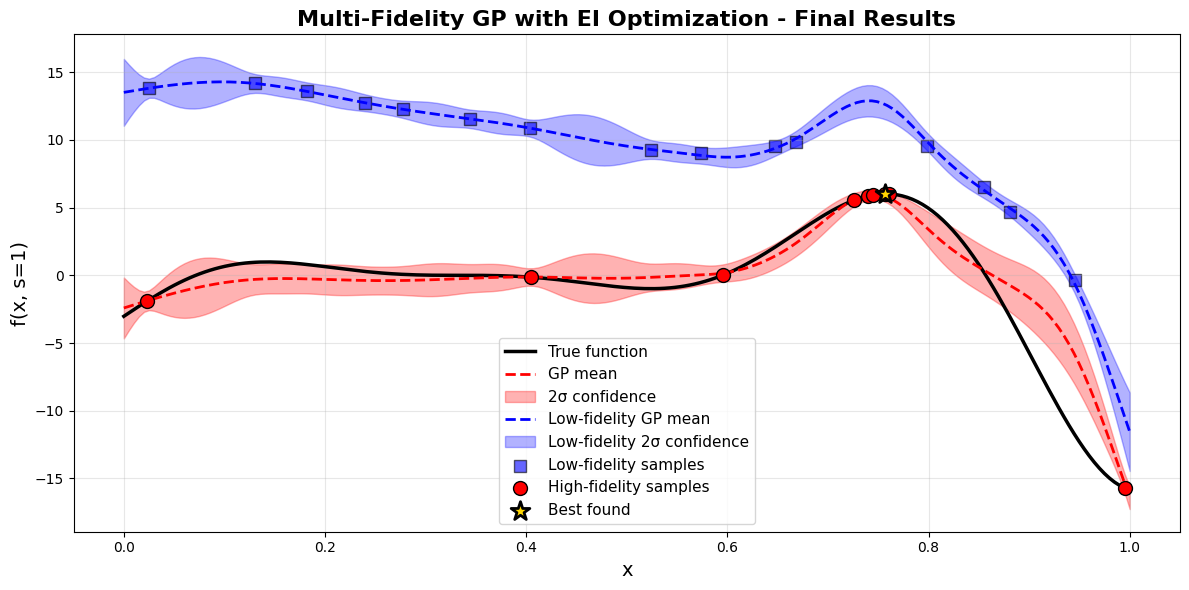


Final Results:
Best x: 0.756744
Best y: 6.020604
Total high-fidelity evaluations: 9
Total low-fidelity evaluations: 15


In [10]:
# Get final predictions
with torch.no_grad():
    posterior_high = model.posterior(X_test_high)
    mean_high = posterior_high.mean.squeeze()
    std_high = posterior_high.variance.sqrt().squeeze()

    posterior_low = model.posterior(X_test_low)
    mean_low = posterior_low.mean.squeeze()
    std_low = posterior_low.variance.sqrt().squeeze()

# Separate training data by fidelity
low_fidelity_mask = train_X[:, 1] == 0.0
high_fidelity_mask = train_X[:, 1] == 1.0

X_low_final = train_X[low_fidelity_mask, 0]
y_low_final = train_y[low_fidelity_mask]  
X_high_final = train_X[high_fidelity_mask, 0]
y_high_final = train_y[high_fidelity_mask]  

# Plot final results
plt.figure(figsize=(12, 6))
plt.plot(X_test.numpy(), y_test_high_true.numpy(), 'k-', label='True function', linewidth=2.5)
plt.plot(X_test.numpy(), mean_high.numpy(), 'r--', label='GP mean', linewidth=2)
plt.fill_between(X_test.numpy().squeeze(), 
                  (mean_high - 2*std_high).numpy(), 
                  (mean_high + 2*std_high).numpy(), 
                  alpha=0.3, color='red', label='2σ confidence')

plt.plot(X_test.numpy(), mean_low.numpy(), 'b--', label='Low-fidelity GP mean', linewidth=2)
plt.fill_between(X_test.numpy().squeeze(), 
                  (mean_low - 2*std_low).numpy(), 
                  (mean_low + 2*std_low).numpy(), 
                  alpha=0.3, color='blue', label='Low-fidelity 2σ confidence')

plt.scatter(X_low_final.numpy(), y_low_final.numpy(), c='blue', s=80, 
            marker='s', alpha=0.6, label='Low-fidelity samples', edgecolors='black')
plt.scatter(X_high_final.numpy(), y_high_final.numpy(), c='red', s=100, 
            marker='o', label='High-fidelity samples', edgecolors='black', zorder=5)



# Mark the best point
best_idx = y_high_final.argmax()  # min of actual values
best_x_final = X_high_final[best_idx]
best_y_final = y_high_final[best_idx]
plt.scatter([best_x_final.numpy()], [best_y_final.numpy()], c='gold', s=200, 
            marker='*', label='Best found', edgecolors='black', zorder=10, linewidths=2)

plt.xlabel('x', fontsize=14)
plt.ylabel('f(x, s=1)', fontsize=14)
plt.title('Multi-Fidelity GP with EI Optimization - Final Results', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Final Results:")
print(f"{'='*60}")
print(f"Best x: {best_x_final.item():.6f}")
print(f"Best y: {best_y_final.item():.6f}")
print(f"Total high-fidelity evaluations: {high_fidelity_mask.sum().item()}")
print(f"Total low-fidelity evaluations: {low_fidelity_mask.sum().item()}")